In [1]:
!pip install openpyxl

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pathlib import Path

import sys

import boto3
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

import seaborn as sns

import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
cwd = Path.cwd()
data_path = cwd / "data" / "Dry_Bean_Dataset.xlsx"
# Convert Excel to csv 
beans = pd.read_excel(data_path)
beans.to_csv(cwd / "data" / "dry_bean.csv", index=False)

In [4]:
sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()
region = sess.boto_session.region_name
BUCKET_URI = "s3://my-ml-databucket"
BUCKET_NAME = "my-ml-databucket"
DATASET_PATH = f"{BUCKET_URI}/dry_bean.csv"
TARGET_NAME = "Class"

In [5]:
print(DATASET_PATH)
# csv_path = cwd / "data" / "dry_bean.csv"
dry_bean = pd.read_csv(DATASET_PATH) # DATASET_PATH if S3
dry_bean.head()

s3://my-ml-databucket/dry_bean.csv


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [6]:
# Exploratory data Analysis

In [7]:
dry_bean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

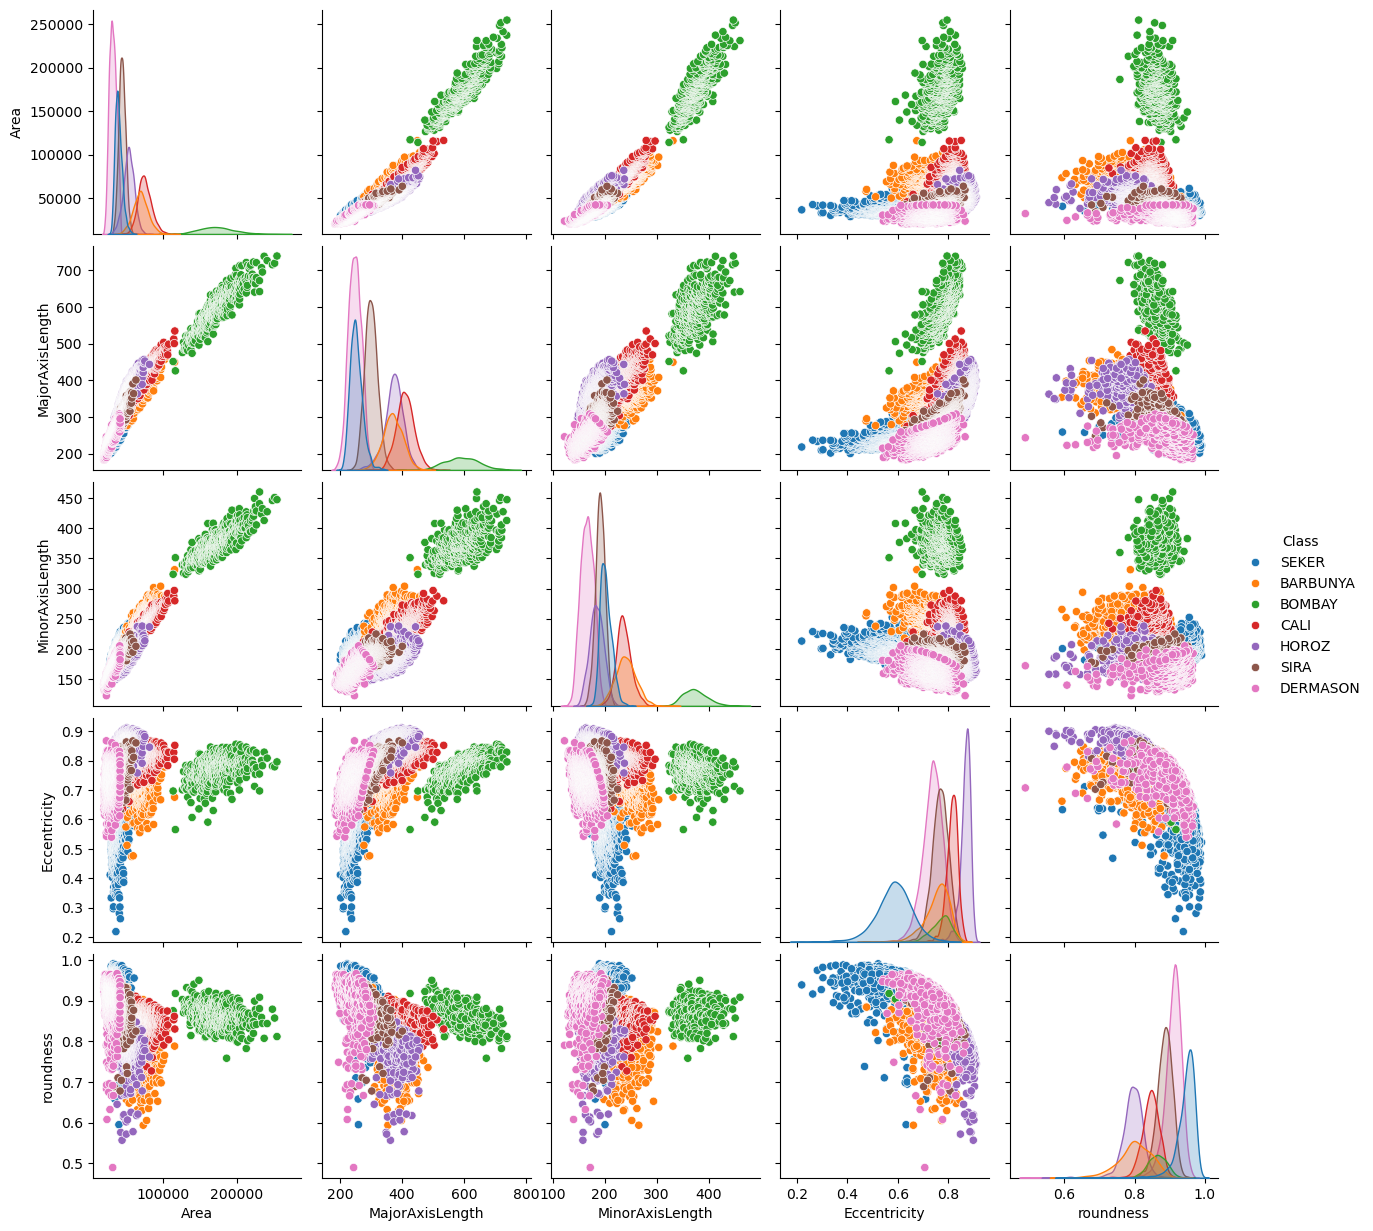

In [8]:
# the beans are clearly distinct in terms of their physical measurements. The green beans (Bombay) are especially well-defined.
sns.pairplot(
   dry_bean,
   vars=["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "roundness"],
   hue="Class",
);

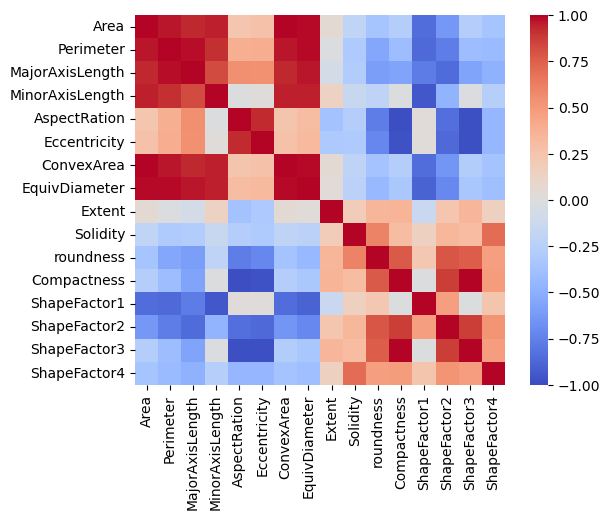

In [9]:
# plot a correlation matrix to see the relationship between features:
correlation = dry_bean.corr(numeric_only=True)

# Create a square heatmap with center at 0
sns.heatmap(correlation, center=0, square=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

# perfectly correlated (positive and negative) features, which makes sense since all features are related to physical measurements.

In [10]:
# Clean Dataset for anamolies 
from sklearn.preprocessing import LabelEncoder

# For preprocessing
df = dry_bean.copy(deep=True)

# Encode the target
le = LabelEncoder()
df[TARGET_NAME] = le.fit_transform(df[TARGET_NAME])

In [11]:
# Split dataset
from sklearn.model_selection import train_test_split

# Split the data into two sets
train, test = train_test_split(df, random_state=1, test_size=0.2)

# train_path = cwd / "data" / "dry-bean-train.csv"
train.to_csv("dry-bean-train.csv")

# Send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
   path="dry-bean-train.csv",
   bucket=BUCKET_NAME,
   key_prefix="sagemaker/sklearncontainer",
)

# test_path = cwd / "data" / "dry-bean-test.csv"
test.to_csv("dry-bean-test.csv")

testpath = sess.upload_data(
   path="dry-bean-test.csv",
   bucket=BUCKET_NAME,
   key_prefix="sagemaker/sklearncontainer",
)

print(f"trainpath : {trainpath}")
print(f"testpath : {testpath}")

trainpath : s3://my-ml-databucket/sagemaker/sklearncontainer/dry-bean-train.csv
testpath : s3://my-ml-databucket/sagemaker/sklearncontainer/dry-bean-test.csv


In [12]:
%%writefile script.py
# Training 
import argparse
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

if __name__ == "__main__":
   print("extracting arguments")
   parser = argparse.ArgumentParser()

   # Hyperparameters sent by the client are passed as command-line arguments to the script.
   parser.add_argument("--n-estimators", type=int, default=10)
   parser.add_argument("--min-samples-leaf", type=int, default=3)

   # Data, model, and output directories
   print("----env variables---")   
   # print(os.environ)
   # print(os.environ.get("SM_MODEL_DIR")) 
   # print(os.environ.get("SM_CHANNEL_TRAIN")) 
   # print(os.environ.get("SM_CHANNEL_TEST")) 
   parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
   parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
   parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
   parser.add_argument("--train-file", type=str, default="dry-bean-train.csv")
   parser.add_argument("--test-file", type=str, default="dry-bean-test.csv")
   args, _ = parser.parse_known_args()

   print("reading data")
   train_df = pd.read_csv(os.path.join(args.train, args.train_file))
   test_df = pd.read_csv(os.path.join(args.test, args.test_file))

   print("building training and testing datasets")

   X_train = train_df.drop("Class", axis=1)
   X_test = test_df.drop("Class", axis=1)
   y_train = train_df[["Class"]]
   y_test = test_df[["Class"]]

   # Train model
   print("training model")

   model = RandomForestClassifier(
       n_estimators=args.n_estimators,
       min_samples_leaf=args.min_samples_leaf,
       n_jobs=-1,
   )

   model.fit(X_train, y_train)

   # Print abs error
   print("validating model")

   bal_acc_train = balanced_accuracy_score(y_train, model.predict(X_train))
   bal_acc_test = balanced_accuracy_score(y_test, model.predict(X_test))

   print(f"Train balanced accuracy: {bal_acc_train:.3f}")
   print(f"Test balanced accuracy: {bal_acc_test:.3f}")

   # Persist model
   path = os.path.join(args.model_dir, "model.joblib")
   joblib.dump(model, path)
   print("model persisted at " + path)

  


Overwriting script.py


In [13]:
#  Model Run 
! python script.py --n-estimators 100 --min-samples-leaf 2 --model-dir ./ --train ./ --test ./

extracting arguments
----env variables---
reading data
building training and testing datasets
training model
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
validating model
Train balanced accuracy: 1.000
Test balanced accuracy: 0.998
model persisted at ./model.joblib
